# Unicorn Dataset

In [63]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

In [64]:
%%capture
import math

import numpy as np
import scipy.io as sio
from sklearn.cross_decomposition import CCA
from sklearn.metrics import confusion_matrix,accuracy_score
from scipy.signal import butter, filtfilt
from  utilss import *

In [65]:
def bandpass_filter(data, lowcut, highcut, sample_rate, order):

    b, a = butter(order, [lowcut, highcut], btype='band',fs=sample_rate)
    y = filtfilt(b, a, data)

    return y

def get_filtered_eeg(eeg, lowcut, highcut, order, sample_rate):
    
    num_classes = eeg.shape[0]
    num_chan = eeg.shape[1]
    total_trial_len = eeg.shape[2]
    num_trials = eeg.shape[3]
    
    trial_len = int(0.135*sample_rate+4*sample_rate-1) - int(0.135*sample_rate)
    filtered_data = np.zeros((eeg.shape[0], eeg.shape[1], trial_len, eeg.shape[3]))
  

    for target in range(eeg.shape[0]):
        for channel in range(eeg.shape[1]):
            for trial in range(eeg.shape[3]):
                signal_to_filter = np.squeeze(eeg[target, channel, int(0.135*sample_rate) : int(0.135*sample_rate+4*sample_rate-1), trial])
                
                filtered_data[target, channel, :, trial] = bandpass_filter(signal_to_filter, lowcut, 
                                                                                  highcut, sample_rate, order)
    return filtered_data


In [66]:

def get_segmented_epochs(data, window_len, shift_len, sample_rate):
    
    num_classes = data.shape[0]
    num_chan = data.shape[1]
    num_trials = data.shape[3]
    duration = int(window_len*sample_rate)
    data_overlap = (window_len - shift_len)* sample_rate
    
    number_of_segments = int(math.ceil((data.shape[2] - data_overlap)/
                                       (duration - data_overlap)))
    
    segmented_data = np.zeros((data.shape[0], data.shape[1], 
                               data.shape[3], number_of_segments, duration))

    for target in range(num_classes):
        for channel in range(num_chan):
            for trial in range(num_trials):
                segmented_data[target, channel, trial, :, :] = buffer(data[target, channel, :, trial], 
                                                                      duration, data_overlap) 
    
    return segmented_data

In [67]:
data_path = os.path.abspath('D:\Downloads\ISN2024\AIN_AUC_SSVEP_Unicorn_Dataset_raw - Copy\AAA')
all_segment_data = dict()
all_acc = list()
window_len = 5
shift_len = 5
sample_rate = 250
duration = int(window_len*sample_rate)
flicker_freq = np.array([15, 10, 12, 16])

In [68]:
def get_cca_reference_signals(data_len, target_freq, sampling_rate):
    reference_signals = []
    t = np.arange(0, (data_len/(sampling_rate)), step=1.0/(sampling_rate))
    reference_signals.append(np.sin(np.pi*2*target_freq*t))
    reference_signals.append(np.cos(np.pi*2*target_freq*t))
    reference_signals.append(np.sin(np.pi*4*target_freq*t))
    reference_signals.append(np.cos(np.pi*4*target_freq*t))
    reference_signals = np.array(reference_signals)
    
    return reference_signals

def find_correlation(n_components, np_buffer, freq):
    cca = CCA(n_components)
    corr = np.zeros(n_components)
    result = np.zeros(freq.shape[0])

    for freq_idx in range(0,freq.shape[0]):
        cca.fit(np_buffer.T,np.squeeze(freq[freq_idx, :, :]).T)
        O1_a,O1_b = cca.transform(np_buffer.T, np.squeeze(freq[freq_idx, :, :]).T)
        corr = np.corrcoef(O1_a[: ,0], O1_b[:, 0])[0 ,1]        
        result[freq_idx] = corr
    
    return result

def cca_classify(segmented_data, reference_templates):
    predicted_class = []
    labels = []
    for target in range(0, segmented_data.shape[0]):
        for trial in range(0, segmented_data.shape[2]):
            for segment in range(0, segmented_data.shape[3]):
                labels.append(target)

                result = find_correlation(1, segmented_data[target, :, trial, segment, :], 
                                      reference_templates)
                predicted_class.append(np.argmax(result)+1)
    labels = np.array(labels)+1
    predicted_class = np.array(predicted_class)

    return labels, predicted_class

# Load dataset, filter and segment epochs
filter and segement the data

In [69]:
for subject in np.arange(0, 7):
    dataset = sio.loadmat(f'{data_path}/s{subject+1}.mat')
    eeg = np.array(dataset['eeg_data'], dtype='float32')
    
    num_classes = eeg.shape[0]
    n_ch = eeg.shape[1]
    total_trial_len = eeg.shape[2]
    num_trials = eeg.shape[3]
    
    filtered_data = get_filtered_eeg(eeg, 6, 80, 4, sample_rate)
    
    
    all_segment_data[f's{subject+1}'] = get_segmented_epochs(filtered_data, window_len, shift_len, sample_rate)

# Generating the required sinusoidal templates for the given 12-class SSVEP classification

In [70]:
reference_templates = []
for fr in range(0, len(flicker_freq)):
    reference_templates.append(get_cca_reference_signals(duration, flicker_freq[fr], sample_rate))
reference_templates = np.array(reference_templates, dtype='float32')

# Perform CCA on the segmented epochs

In [71]:
for subject in all_segment_data.keys():
    labels, predicted_class = cca_classify(all_segment_data[subject], reference_templates)

    acc=accuracy_score(labels, predicted_class)
    all_acc.append(acc)
    print(f'Subject: {subject}, Accuracy: {acc*100} %')

Subject: s1, Accuracy: 31.25 %
Subject: s2, Accuracy: 25.0 %
Subject: s3, Accuracy: 6.25 %
Subject: s4, Accuracy: 34.375 %
Subject: s5, Accuracy: 25.0 %
Subject: s6, Accuracy: 34.375 %
Subject: s7, Accuracy: 31.25 %


In [72]:
all_acc = np.array(all_acc)
print(f'Overall Accuracy Across Subjects: {np.mean(all_acc)*100} %, std: {np.std(all_acc)*100} %')

Overall Accuracy Across Subjects: 26.785714285714285 %, std: 9.127253705473603 %


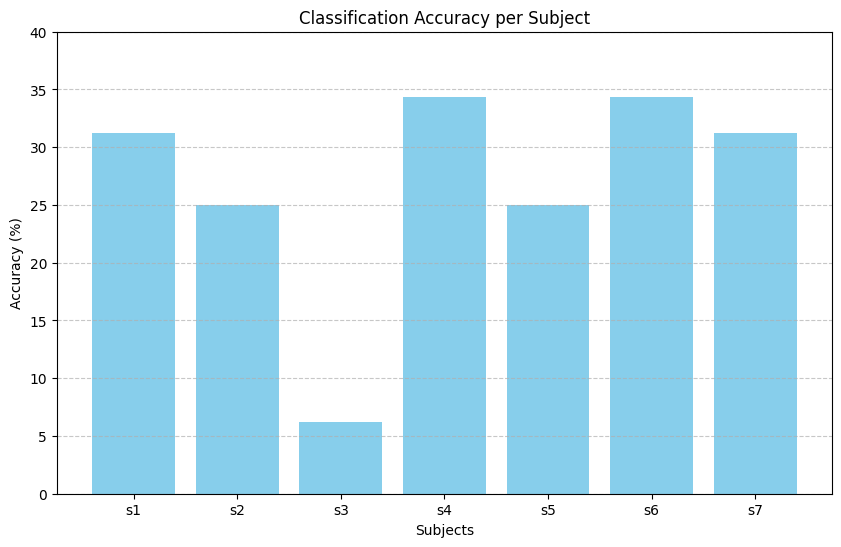

In [74]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Assuming all_segment_data and reference_templates are already defined
all_acc = []
subject_ids = []

# Compute accuracy for each subject
for subject in all_segment_data.keys():
    labels, predicted_class = cca_classify(all_segment_data[subject], reference_templates)
    acc = accuracy_score(labels, predicted_class)
    all_acc.append(acc * 100)  # Convert to percentage
    subject_ids.append(subject)  # Store subject ID

# Plotting the accuracies
plt.figure(figsize=(10, 6))
plt.bar(subject_ids, all_acc, color='skyblue')
plt.xlabel('Subjects')
plt.ylabel('Accuracy (%)')
plt.title('Classification Accuracy per Subject')
plt.ylim(0, 40)  # Adjust based on your accuracy range
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
